# Predicción del nivel de almacenamiento de las presas de Sonora

## 0. Introducción 

Este proyecto tiene por objetivo principal la predicción del nivel de almacenamiento de las presas de Sonora. 

In [1]:
#!pip install tensorflow

In [2]:
# Comenzamos importando las librerías necesarias
import numpy as np
np.random.seed(4)
import pandas as pd
import os

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Manejo de series de tiempo
from datetime import datetime, timedelta
import time

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Modelo
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

## 1. Carga y transformación de datos

### 1.1 Carga de datos

In [3]:
df = pd.read_csv(r".\datos\presas2024.csv")

In [4]:
# Convertir la columna fecha a tipo fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')

# Revisar si hay alguna fecha que haya fallado al convertirla
failed_conversion = df[df['Fecha'].isna()]
if not failed_conversion.empty:
    print("No se pudieron convertir las siguientes fechas:")
    print(failed_conversion)

# Visualizamos el dataframe para confirmar la conversión
df.head()

Clave      Fecha  Almacenamiento(hm³)
0  LCDSO 1941-07-01                 0.13
1  LCDSO 1941-07-02                 0.15
2  LCDSO 1941-07-03                 0.16
3  LCDSO 1941-07-04                 0.16
4  LCDSO 1941-07-05                 0.15

In [5]:
# Cambiar nombre de columnas
df.columns = ["Presa", "Fecha", "Almacenamiento"]
df.head()

Presa      Fecha Almacenamiento
0  LCDSO 1941-07-01           0.13
1  LCDSO 1941-07-02           0.15
2  LCDSO 1941-07-03           0.16
3  LCDSO 1941-07-04           0.16
4  LCDSO 1941-07-05           0.15

### 1.2 Consistencia de datos

In [6]:
# Filtrar valores en la columna 'Almacenamiento' que contienen al menos una coma
valores_con_coma = df[df['Almacenamiento'].str.contains(',', na=False)]
valores_con_coma

Presa      Fecha Almacenamiento
208058  AOBSO 2023-07-20       1,252.51
208066  AOBSO 2023-07-21       1,253.56
208108  AOBSO 2023-07-25       1,258.81
208116  AOBSO 2023-07-26       1,260.91
208128  AOBSO 2023-07-27       1,263.01
208136  AOBSO 2023-07-28       1,266.16
208567  AOBSO 2023-09-09       1,357.45
208577  AOBSO 2023-09-10       1,363.00
208587  AOBSO 2023-09-11       1,367.43
208597  AOBSO 2023-09-12       1,370.76
208607  AOBSO 2023-09-13       1,374.08
208787  AOBSO 2023-10-01       1,428.40
208797  AOBSO 2023-10-02       1,430.62
208807  AOBSO 2023-10-03       1,432.83
208817  AOBSO 2023-10-04       1,430.62

In [7]:
# Eliminar las comas y reemplazarlas por valores vacíos (NaN)
df['Almacenamiento'] = df['Almacenamiento'].str.replace(',', '', regex=False)
df[df['Almacenamiento'].str.contains(',', na=False)]

Empty DataFrame
Columns: [Presa, Fecha, Almacenamiento]
Index: []

### 1.3 Construcción de la serie de tiempo

In [8]:
df.Presa.unique()

array(['LCDSO', 'ARLSO', 'CHTSO', 'AOBSO', 'ARCSO', 'AGZCH', 'PECSO',
       'IRASO', 'PMOSO', 'BICSO'], dtype=object)

In [9]:
# Transformar el DataFrame de formato largo a ancho
df_wide = df.pivot(index='Fecha', columns='Presa', values='Almacenamiento')

# Mostrar el DataFrame transformado
print("\nDataFrame Transformado a Formato Ancho:")
df_wide


DataFrame Transformado a Formato Ancho:


Presa       AGZCH   AOBSO  ARCSO ARLSO  BICSO CHTSO IRASO  LCDSO   PECSO PMOSO
Fecha                                                                         
1941-07-01    NaN     NaN    NaN   NaN    NaN   NaN   NaN   0.13     NaN   NaN
1941-07-02    NaN     NaN    NaN   NaN    NaN   NaN   NaN   0.15     NaN   NaN
1941-07-03    NaN     NaN    NaN   NaN    NaN   NaN   NaN   0.16     NaN   NaN
1941-07-04    NaN     NaN    NaN   NaN    NaN   NaN   NaN   0.16     NaN   NaN
1941-07-05    NaN     NaN    NaN   NaN    NaN   NaN   NaN   0.15     NaN   NaN
...           ...     ...    ...   ...    ...   ...   ...    ...     ...   ...
2024-06-22  11.04  382.48  10.56     0  10.77  0.68     0  83.24  292.61  5.83
2024-06-23  10.99  380.59  10.59     0  10.84  0.68     0  82.79  292.61  5.83
2024-06-24  10.81  379.68  10.59     0  10.83  0.66     0  82.23  295.79  5.83
2024-06-25  10.81  378.77  10.59     0  10.81  0.62     0  81.78  296.78  5.78
2024-06-26   10.6  377.86  10.59     0   10.8  0.61  0.17  81.22  296.78  5.73

[30312 rows x 10 columns]

Como la presa Bicentenario (BICSO) inició operaciones en 2023 vamos a eliminarla del presente análisis. 

In [10]:
df_wide = df_wide.drop(columns="BICSO")
df_wide

Presa       AGZCH   AOBSO  ARCSO ARLSO CHTSO IRASO  LCDSO   PECSO PMOSO
Fecha                                                                  
1941-07-01    NaN     NaN    NaN   NaN   NaN   NaN   0.13     NaN   NaN
1941-07-02    NaN     NaN    NaN   NaN   NaN   NaN   0.15     NaN   NaN
1941-07-03    NaN     NaN    NaN   NaN   NaN   NaN   0.16     NaN   NaN
1941-07-04    NaN     NaN    NaN   NaN   NaN   NaN   0.16     NaN   NaN
1941-07-05    NaN     NaN    NaN   NaN   NaN   NaN   0.15     NaN   NaN
...           ...     ...    ...   ...   ...   ...    ...     ...   ...
2024-06-22  11.04  382.48  10.56     0  0.68     0  83.24  292.61  5.83
2024-06-23  10.99  380.59  10.59     0  0.68     0  82.79  292.61  5.83
2024-06-24  10.81  379.68  10.59     0  0.66     0  82.23  295.79  5.83
2024-06-25  10.81  378.77  10.59     0  0.62     0  81.78  296.78  5.78
2024-06-26   10.6  377.86  10.59     0  0.61  0.17  81.22  296.78  5.73

[30312 rows x 9 columns]

#### 1.3.1 Selección del rango temporal a incluir en la serie de tiempo

In [11]:
# Encontrar el índice del primer valor distinto de NaN para cada columna
first_valid_indices = df_wide.apply(lambda x: x.first_valid_index())
first_valid_indices

Presa
AGZCH   1963-01-01
AOBSO   1952-06-01
ARCSO   1955-07-01
ARLSO   1947-04-14
CHTSO   1950-02-01
IRASO   1971-08-01
LCDSO   1941-07-01
PECSO   1964-01-01
PMOSO   1993-02-01
dtype: datetime64[ns]

In [12]:
fecha_inicio = first_valid_indices.max()
df_wide = df_wide[df_wide.index >= fecha_inicio]
df_wide

Presa       AGZCH   AOBSO   ARCSO   ARLSO  CHTSO  IRASO   LCDSO    PECSO  \
Fecha                                                                      
1993-02-01  62.81    2769  695.27  233.34  62.63  25.39  933.91   2961.9   
1993-02-02  62.81    2769   692.2   231.8  62.56  25.23  929.81   2961.9   
1993-02-03  62.75  2770.5   687.6  231.41  62.56  25.07  926.53  2960.88   
1993-02-04  62.69    2772  684.02  231.03  62.56  25.23  922.84   2957.8   
1993-02-05  62.64    2772  679.41  230.64  62.56  24.55  919.56  2955.75   
...           ...     ...     ...     ...    ...    ...     ...      ...   
2024-06-22  11.04  382.48   10.56       0   0.68      0   83.24   292.61   
2024-06-23  10.99  380.59   10.59       0   0.68      0   82.79   292.61   
2024-06-24  10.81  379.68   10.59       0   0.66      0   82.23   295.79   
2024-06-25  10.81  378.77   10.59       0   0.62      0   81.78   296.78   
2024-06-26   10.6  377.86   10.59       0   0.61   0.17   81.22   296.78   

Presa        PMOSO  
Fecha               
1993-02-01   143.2  
1993-02-02  144.02  
1993-02-03   145.2  
1993-02-04   145.9  
1993-02-05   146.2  
...            ...  
2024-06-22    5.83  
2024-06-23    5.83  
2024-06-24    5.83  
2024-06-25    5.78  
2024-06-26    5.73  

[11469 rows x 9 columns]

In [13]:
fecha_fin = df_wide.index.max()
fecha_fin

Timestamp('2024-06-26 00:00:00')

### 1.4 Verificación de periodicidad y consistencia temporal

#### 1.4.1 Periodicidad de las series de tiempo

In [14]:
# Generar un rango de fechas esperadas
rango_fechas_esperadas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
rango_fechas_esperadas

DatetimeIndex(['1993-02-01', '1993-02-02', '1993-02-03', '1993-02-04',
               '1993-02-05', '1993-02-06', '1993-02-07', '1993-02-08',
               '1993-02-09', '1993-02-10',
               ...
               '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20',
               '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24',
               '2024-06-25', '2024-06-26'],
              dtype='datetime64[ns]', length=11469, freq='D')

In [15]:
# Comparar con las fechas actuales para identificar fechas faltantes
fechas_faltantes = rango_fechas_esperadas.difference(df_wide.index)
fechas_faltantes

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [16]:
# Verificar si hay índices duplicados
indices_duplicados = df_wide.index[df_wide.index.duplicated()]
indices_duplicados

DatetimeIndex([], dtype='datetime64[ns]', name='Fecha', freq=None)

#### 1.4.2 Fechas con valores faltantes

In [17]:
df_wide_num = df_wide.apply(pd.to_numeric, errors='coerce')

In [18]:
df_wide_num.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11469 entries, 1993-02-01 to 2024-06-26
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGZCH   11469 non-null  float64
 1   AOBSO   11469 non-null  float64
 2   ARCSO   11469 non-null  float64
 3   ARLSO   11469 non-null  float64
 4   CHTSO   11469 non-null  float64
 5   IRASO   11255 non-null  float64
 6   LCDSO   11469 non-null  float64
 7   PECSO   11469 non-null  float64
 8   PMOSO   11467 non-null  float64
dtypes: float64(9)
memory usage: 896.0 KB


In [19]:
df_wide_num.isna().sum()

Presa
AGZCH      0
AOBSO      0
ARCSO      0
ARLSO      0
CHTSO      0
IRASO    214
LCDSO      0
PECSO      0
PMOSO      2
dtype: int64

##### 1.4.2.1 Datos faltantes de IRASO

In [20]:
# Calcular el valor máximo y mínimo
maximo = df_wide["IRASO"].loc[df_wide_num.IRASO.isna()].index.max()
minimo = df_wide["IRASO"].loc[df_wide_num.IRASO.isna()].index.min()

print("minimo: " , minimo, '\n')
print("maximo: " , maximo)


minimo:  1993-08-01 00:00:00 

maximo:  1994-09-30 00:00:00


In [21]:
# Crear un DataFrame con las fechas y sus diferencias
df_faltantes_iraso = pd.DataFrame({
    'Fecha': df_wide["IRASO"].loc[df_wide_num.IRASO.isna()].index})

df_faltantes_iraso['Fecha_siguiente'] = df_faltantes_iraso['Fecha'].shift(-1)

# Calcular la diferencia en días
df_faltantes_iraso['Diferencia_en_dias'] = (df_faltantes_iraso['Fecha_siguiente'] - df_faltantes_iraso['Fecha']).dt.days
df_faltantes_iraso.loc[df_faltantes_iraso['Diferencia_en_dias']>1]

Fecha Fecha_siguiente  Diferencia_en_dias
30 1993-08-31      1994-04-01               213.0

In [22]:
(pd.to_datetime('1993-08-31') - minimo).days

30

In [23]:
(maximo - pd.to_datetime('1994-04-01')).days

182

Para el manejo de datos faltantes en una serie de tiempo, es común aplicar interpolación, siempre y cuando los valores vacíos no excedan un límite determinado y no se extiendan por períodos prolongados. Observamos que la serie de tiempo del almacenamiento de la presa IRASO presenta dos intervalos con valores faltantes: del 1 de agosto de 1993 al 31 de agosto de 1993, y del 1 de abril de 1994 al 30 de septiembre de 1994. Estos intervalos representan aproximadamente un mes y seis meses, respectivamente. Debido a la extensión amplia de estos rangos y a los cambios climatológicos, es recomendable establecer a nuestra serie de tiempo a partir de 1994-10-01 y hasta la fecha más reciente.

In [24]:
fecha_inicio = pd.to_datetime('1994-10-01')

In [25]:
df_wide_num = df_wide_num[df_wide_num.index >= fecha_inicio]
df_wide = df_wide[df_wide.index >= fecha_inicio]
df_wide_num

Presa       AGZCH    AOBSO   ARCSO   ARLSO  CHTSO  IRASO   LCDSO    PECSO  \
Fecha                                                                       
1994-10-01  31.52  2635.20  679.41  123.13  38.65  27.65  574.80  1638.20   
1994-10-02  31.52  2640.00  678.90  122.86  38.60  27.61  574.80  1638.90   
1994-10-03  31.56  2640.00  678.39  122.61  38.60  27.57  574.80  1638.90   
1994-10-04  31.56  2638.40  677.37  122.35  38.55  27.57  574.20  1643.10   
1994-10-05  31.56  2635.20  674.81  122.11  38.50  27.53  573.60  1645.20   
...           ...      ...     ...     ...    ...    ...     ...      ...   
2024-06-22  11.04   382.48   10.56    0.00   0.68   0.00   83.24   292.61   
2024-06-23  10.99   380.59   10.59    0.00   0.68   0.00   82.79   292.61   
2024-06-24  10.81   379.68   10.59    0.00   0.66   0.00   82.23   295.79   
2024-06-25  10.81   378.77   10.59    0.00   0.62   0.00   81.78   296.78   
2024-06-26  10.60   377.86   10.59    0.00   0.61   0.17   81.22   296.78   

Presa       PMOSO  
Fecha              
1994-10-01  11.99  
1994-10-02  11.95  
1994-10-03  11.82  
1994-10-04  11.65  
1994-10-05  11.57  
...           ...  
2024-06-22   5.83  
2024-06-23   5.83  
2024-06-24   5.83  
2024-06-25   5.78  
2024-06-26   5.73  

[10862 rows x 9 columns]

In [26]:
df_wide_num.isna().sum()

Presa
AGZCH    0
AOBSO    0
ARCSO    0
ARLSO    0
CHTSO    0
IRASO    0
LCDSO    0
PECSO    0
PMOSO    1
dtype: int64

##### 1.4.2.2 Datos faltantes de PMOSO

In [27]:
df_wide["PMOSO"].loc[df_wide_num.PMOSO.isna()]

Fecha
2004-05-22    NaN
Name: PMOSO, dtype: object

In [28]:
# Aplicar interpolación cúbica a la columna PMOSO
df_wide_num['PMOSO'] = df_wide_num['PMOSO'].interpolate(method='linear')
df_wide_num.PMOSO.isna().sum()

0

In [29]:
df_wide_num.loc[(df_wide_num.index >= pd.to_datetime('2004-05-20')) & (df_wide_num.index <= pd.to_datetime('2004-05-24'))]

Presa       AGZCH  AOBSO  ARCSO  ARLSO  CHTSO  IRASO  LCDSO   PECSO  PMOSO
Fecha                                                                     
2004-05-20  22.86  276.6  49.44   0.01  19.53   6.57  60.56  568.00   4.39
2004-05-21  22.71  275.9  49.44   0.01  19.47   6.50  60.37  567.68   4.37
2004-05-22  22.50  275.2  49.44   0.01  19.41   6.44  60.18  568.00   4.37
2004-05-23  22.32  274.5  49.44   0.01  19.35   6.37  59.90  568.00   4.37
2004-05-24  22.11  273.8  49.44   0.01  19.26   6.31  59.62  567.61   4.35

### 1.5 Visualización de las series de tiempo

In [30]:
# Crear la figura de Plotly
fig = go.Figure()

# Agregar la línea para cada presa
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['AGZCH'], mode='lines', name='AGZCH'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['AOBSO'], mode='lines', name='AOBSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['ARCSO'], mode='lines', name='ARCSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['ARLSO'], mode='lines', name='ARLSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['CHTSO'], mode='lines', name='CHTSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['IRASO'], mode='lines', name='IRASO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['LCDSO'], mode='lines', name='LCDSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['PECSO'], mode='lines', name='PECSO'))
fig.add_trace(go.Scatter(x=df_wide_num.index, y=df_wide_num['PMOSO'], mode='lines', name='PMOSO'))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Histórico de Almacenamiento de Presas',
    xaxis_title='Fecha',
    yaxis_title='Almacenamiento (hm³)',
    width=1700,
    height=500
)

# Mostrar el gráfico interactivo
fig.show()

In [31]:
# # Convertir a formato largo usando melt
# df_long = pd.melt(df_wide_num.reset_index(), id_vars=['Fecha'], var_name='Presa', value_name='Almacenamiento')

# # Establecer 'Fecha' como índice
# df_long.set_index('Fecha', inplace=True)

# # Aplicar one-hot encoding a la columna 'Presa'
# df_long = pd.get_dummies(df_long, columns=['Presa'], prefix='', prefix_sep='')
# df_long = df_long.apply(pd.to_numeric, errors='coerce')

# df_long

## 2. Construcción de los conjuntos de entrenamiento y validación

In [32]:
set_entrenamiento = df_wide_num[:pd.to_datetime('31-12-2021', dayfirst=True)]
set_validacion = df_wide_num[pd.to_datetime('01-01-2022', dayfirst=True):]

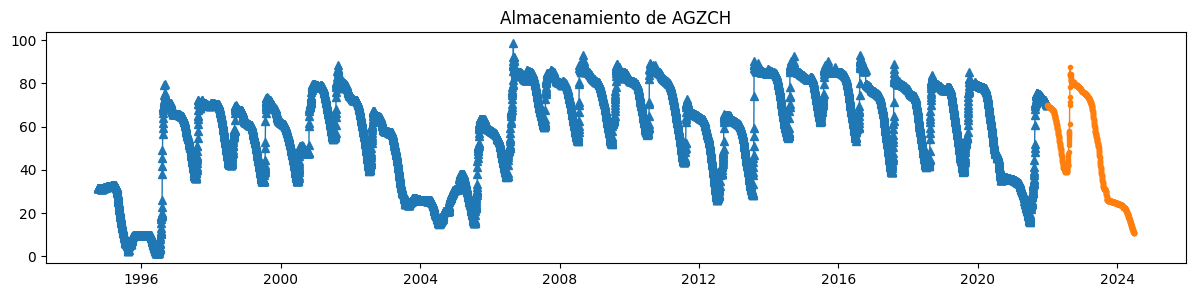

In [33]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Almacenamiento de AGZCH")
ax1.plot(set_entrenamiento.AGZCH,marker='^',linewidth=1)
ax1.plot(set_validacion.AGZCH, marker = '.', linewidth = 1 )
plt.show()

In [34]:
set_entrenamiento

Presa       AGZCH    AOBSO   ARCSO   ARLSO  CHTSO  IRASO   LCDSO    PECSO  \
Fecha                                                                       
1994-10-01  31.52  2635.20  679.41  123.13  38.65  27.65  574.80  1638.20   
1994-10-02  31.52  2640.00  678.90  122.86  38.60  27.61  574.80  1638.90   
1994-10-03  31.56  2640.00  678.39  122.61  38.60  27.57  574.80  1638.90   
1994-10-04  31.56  2638.40  677.37  122.35  38.55  27.57  574.20  1643.10   
1994-10-05  31.56  2635.20  674.81  122.11  38.50  27.53  573.60  1645.20   
...           ...      ...     ...     ...    ...    ...     ...      ...   
2021-12-27  70.18  1388.49  293.40    0.67   5.84   8.64  417.12   905.08   
2021-12-28  70.12  1388.49  291.77    0.67   5.77   8.61  415.05   903.25   
2021-12-29  70.06  1387.38  290.40    0.65   5.72   8.47  412.68   904.17   
2021-12-30  70.00  1386.28  289.04    0.65   5.68   8.39  409.52   905.54   
2021-12-31  69.94  1384.06  287.95    0.65   5.68   8.44  406.35   904.62   

Presa       PMOSO  
Fecha              
1994-10-01  11.99  
1994-10-02  11.95  
1994-10-03  11.82  
1994-10-04  11.65  
1994-10-05  11.57  
...           ...  
2021-12-27  21.34  
2021-12-28  21.29  
2021-12-29  21.24  
2021-12-30  21.19  
2021-12-31  21.19  

[9954 rows x 9 columns]

### 2.1 Preprocesamiento

In [35]:
time_step = 365  # Número de valores a usar para predecir el siguiente
X_train_dict = {}
Y_train_dict = {}

# Convertir set_entrenamiento a un array de NumPy
set_entrenamiento_array = set_entrenamiento.to_numpy()

# Obtener número de filas en set_entrenamiento
m = set_entrenamiento_array.shape[0]

# Iterar sobre cada columna del DataFrame
for col_idx in range(set_entrenamiento_array.shape[1]):
    col_name = set_entrenamiento.columns[col_idx]

    X_train = []
    Y_train = []

    # Crear el MinMaxScaler para la columna actual
    scaler_name = f'scaler_{col_name}'
    globals()[scaler_name] = MinMaxScaler()  # Crear el scaler con el nombre dinámico
    set_entrenamiento_escalado = globals()[scaler_name].fit_transform(set_entrenamiento_array[:, col_idx].reshape(-1, 1))

    # Construir X_train y Y_train para la columna actual
    for i in range(time_step, m):
        # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
        X_train.append(set_entrenamiento_escalado[i-time_step:i, 0])

        # Y: el siguiente dato después del bloque de X_train
        Y_train.append(set_entrenamiento_escalado[i, 0])

    # Convertir listas a arrays de NumPy
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    # Reshape para LSTM (n_samples, time_steps, n_features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Almacenar en el diccionario
    X_train_dict[f'X_train_{col_name}'] = X_train
    Y_train_dict[f'Y_train_{col_name}'] = Y_train

# Verificar formas de algunos conjuntos de datos
for key in X_train_dict:
    print(f"Forma de {key}: {X_train_dict[key].shape}")  # Debe ser (m - time_step, time_step, 1)

for key in Y_train_dict:
    print(f"Forma de {key}: {Y_train_dict[key].shape}")  # Debe ser (m - time_step,)


Forma de X_train_AGZCH: (9589, 365, 1)
Forma de X_train_AOBSO: (9589, 365, 1)
Forma de X_train_ARCSO: (9589, 365, 1)
Forma de X_train_ARLSO: (9589, 365, 1)
Forma de X_train_CHTSO: (9589, 365, 1)
Forma de X_train_IRASO: (9589, 365, 1)
Forma de X_train_LCDSO: (9589, 365, 1)
Forma de X_train_PECSO: (9589, 365, 1)
Forma de X_train_PMOSO: (9589, 365, 1)
Forma de Y_train_AGZCH: (9589,)
Forma de Y_train_AOBSO: (9589,)
Forma de Y_train_ARCSO: (9589,)
Forma de Y_train_ARLSO: (9589,)
Forma de Y_train_CHTSO: (9589,)
Forma de Y_train_IRASO: (9589,)
Forma de Y_train_LCDSO: (9589,)
Forma de Y_train_PECSO: (9589,)
Forma de Y_train_PMOSO: (9589,)


In [36]:
# Llamar al conjunto de datos
X_train_dict['X_train_AGZCH']

array([[[0.30754173],
        [0.30754173],
        [0.30795384],
        ...,
        [0.0787142 ],
        [0.07984752],
        [0.08067175]],

       [[0.30754173],
        [0.30795384],
        [0.30795384],
        ...,
        [0.07984752],
        [0.08067175],
        [0.08139295]],

       [[0.30795384],
        [0.30795384],
        [0.30795384],
        ...,
        [0.08067175],
        [0.08139295],
        [0.08139295]],

       ...,

       [[0.34988667],
        [0.34988667],
        [0.34988667],
        ...,
        [0.70647022],
        [0.70585205],
        [0.70523388]],

       [[0.34988667],
        [0.34988667],
        [0.34947455],
        ...,
        [0.70585205],
        [0.70523388],
        [0.7046157 ]],

       [[0.34988667],
        [0.34947455],
        [0.34947455],
        ...,
        [0.70523388],
        [0.7046157 ],
        [0.70399753]]])

In [37]:
X_valid_dict = {}
Y_valid_dict = {}

# Convertir set_validacion a un array de NumPy
set_validacion_array = set_validacion.to_numpy()

# Iterar sobre cada columna del DataFrame
for col_idx in range(set_validacion_array.shape[1]):
    col_name = set_validacion.columns[col_idx]

    X_valid = []
    Y_valid = []

    # Obtener el MinMaxScaler correspondiente
    scaler_name = f'scaler_{col_name}'
    scaler = globals()[scaler_name]  # Obtener el escalador creado previamente

    # Escalar los datos de validación para la columna actual
    set_validacion_escalado = scaler.transform(set_validacion_array[:, col_idx].reshape(-1, 1))

    # Construir X_valid y Y_valid para la columna actual
    for i in range(time_step, set_validacion_array.shape[0]):
        X_valid.append(set_validacion_escalado[i-time_step:i, 0])
        Y_valid.append(set_validacion_escalado[i, 0])

    # Convertir listas a arrays de NumPy
    X_valid = np.array(X_valid)
    Y_valid = np.array(Y_valid)

    # Reshape para LSTM (n_samples, time_steps, n_features)
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

    # Almacenar en el diccionario
    X_valid_dict[f'X_valid_{col_name}'] = X_valid
    Y_valid_dict[f'Y_valid_{col_name}'] = Y_valid

# Verificar formas de algunos conjuntos de datos de validación
for key in X_valid_dict:
    print(f"Forma de {key}: {X_valid_dict[key].shape}")  # Debe ser (m_valid - time_step, time_step, 1)

for key in Y_valid_dict:
    print(f"Forma de {key}: {Y_valid_dict[key].shape}")  # Debe ser (m_valid - time_step,)


Forma de X_valid_AGZCH: (543, 365, 1)
Forma de X_valid_AOBSO: (543, 365, 1)
Forma de X_valid_ARCSO: (543, 365, 1)
Forma de X_valid_ARLSO: (543, 365, 1)
Forma de X_valid_CHTSO: (543, 365, 1)
Forma de X_valid_IRASO: (543, 365, 1)
Forma de X_valid_LCDSO: (543, 365, 1)
Forma de X_valid_PECSO: (543, 365, 1)
Forma de X_valid_PMOSO: (543, 365, 1)
Forma de Y_valid_AGZCH: (543,)
Forma de Y_valid_AOBSO: (543,)
Forma de Y_valid_ARCSO: (543,)
Forma de Y_valid_ARLSO: (543,)
Forma de Y_valid_CHTSO: (543,)
Forma de Y_valid_IRASO: (543,)
Forma de Y_valid_LCDSO: (543,)
Forma de Y_valid_PECSO: (543,)
Forma de Y_valid_PMOSO: (543,)


## 3. Construcción, entrenamiento y validación de los modelos LSTM

### 3.0 Definición de los modelos

In [38]:
# Definir el modelo LSTM
def crear_modelo(input_shape, nodes=100, lr=0.001):
    
    # Configuración del optimizador, función de pérdida y métricas
    loss = MeanSquaredError()
    metrics = [MeanSquaredError(), MeanAbsoluteError()]  # Agregar MAD como métrica adicional

    # Definición del modelo
    modelo = Sequential()
    modelo.add(LSTM(units=nodes, input_shape=input_shape))
    modelo.add(Dense(units=1))
    modelo.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)  # Crear un nuevo optimizador para cada modelo
    return modelo

# Entrenar el modelo para cada conjunto de datos
historiales = {}

### 3.1 Presa AGZCH

#### 3.1.1 Construcción y entrenamiento del modelo

In [53]:
key = "X_train_AGZCH"
presa = "AGZCH"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Entrenando modelo para AGZCH...
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 405ms/step - loss: 0.0496 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0496
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 153s 509ms/step - loss: 2.2975e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 2.2975e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 113s 376ms/step - loss: 2.1186e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 2.1186e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 114s 381ms/step - loss: 1.5637e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.5638e-04
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 128s 427ms/step - loss: 1.4144e-04 - mean_absolute_error: 0.0074 - mean_squared_error: 1.4144e-04
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 176s 588ms/step - loss: 1.2037e-04 - mean_absolute_error: 0.0067 - mean_squared_error: 1.2037e-04
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 163s 543ms/step - loss: 1.2196e-04 - mean_absolute_error: 0.0065 - mean_squared_error: 1.2196e-04
Epoch 8/10

#### 3.1.2 Guardar el modelo y el historial

In [54]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos", model_filename)

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo, 'modelo_entrenado_AGZCH.h5')
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para AGZCH guardado como modelo_AGZCH.h5


#### 3.1.3 Validación y evaluación del modelo

In [83]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [84]:
X_test.shape, set_validacion.shape

((543, 365, 1), (908, 9))

In [85]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step


In [86]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                
2023-01-01  76.376648
2023-01-02  76.362457
2023-01-03  76.355560
2023-01-04  76.313660
2023-01-05  76.279800
...               ...
2024-06-22  11.122631
2024-06-23  11.001713
2024-06-24  10.918351
2024-06-25  10.806504
2024-06-26  10.745105

[543 rows x 1 columns]

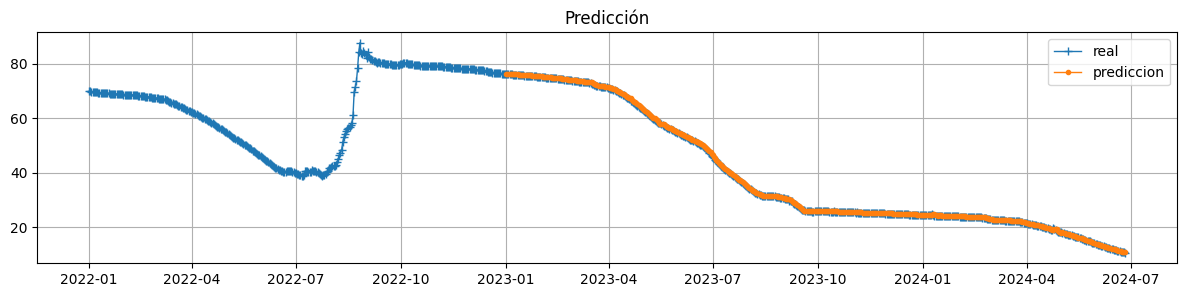

In [89]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [91]:
maximo = np.max(np.abs(set_validacion.AGZCH[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.AGZCH[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 1.1359762573242165
La diferencia mínima es 0.0008169708251948293


### 3.2 Presa AOBSO

#### 3.2.1 Construcción y entrenamiento del modelo

In [39]:
key = "X_train_AOBSO"
presa = "AOBSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Entrenando modelo para AOBSO...
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 412ms/step - loss: 0.0095 - mean_absolute_error: 0.0387 - mean_squared_error: 0.0095
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 119s 397ms/step - loss: 2.0765e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 2.0765e-05
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 343ms/step - loss: 1.8038e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.8038e-05
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 105s 350ms/step - loss: 1.9751e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.9751e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 99s 330ms/step - loss: 1.7373e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.7373e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 342ms/step - loss: 3.0663e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.0663e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 347ms/step - loss: 3.0331e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 3.0331e-05
Epoch 8/10


#### 3.2.2 Guardar el modelo y el historial

In [40]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos", model_filename)

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo, model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para AOBSO guardado como modelo_AOBSO.h5


#### 3.2.3 Validación y evaluación del modelo

In [41]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [42]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


In [44]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                  
2023-01-01  1638.093018
2023-01-02  1642.850830
2023-01-03  1650.719971
2023-01-04  1661.731445
2023-01-05  1667.885620
...                 ...
2024-06-22   391.120209
2024-06-23   389.567230
2024-06-24   386.798492
2024-06-25   384.239716
2024-06-26   383.200287

[543 rows x 1 columns]

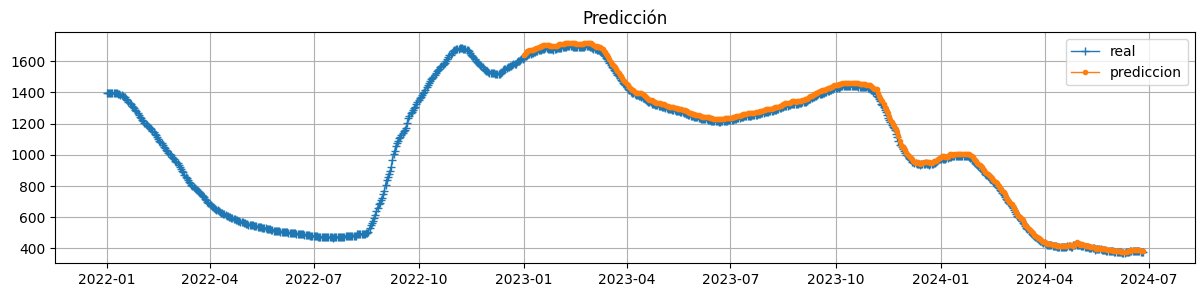

In [45]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.AOBSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [46]:
maximo = np.max(np.abs(set_validacion.AOBSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.AOBSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 41.05812500000002
La diferencia mínima es 0.23063964843754547


### 3.3 Presa ARCSO

#### 3.3.1 Construcción y entrenamiento del modelo

In [47]:
key = "X_train_ARCSO"
presa = "ARCSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para ARCSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 407ms/step - loss: 0.0208 - mean_absolute_error: 0.0729 - mean_squared_error: 0.0208
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 118s 392ms/step - loss: 1.0611e-04 - mean_absolute_error: 0.0063 - mean_squared_error: 1.0611e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 385ms/step - loss: 1.0513e-04 - mean_absolute_error: 0.0064 - mean_squared_error: 1.0513e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 387ms/step - loss: 7.7955e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 7.7955e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 84s 281ms/step - loss: 5.1949e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 5.1948e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - loss: 5.5256e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 5.5256e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 55s 183ms/step - loss: 5.0862e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 5.0863e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 205ms/step -

#### 3.3.2 Guardar el modelo y el historial

In [48]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para ARCSO guardado como modelo_ARCSO.h5


#### 3.3.3 Validación y evaluación del modelo

In [49]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [50]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [51]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                 
2023-01-01  815.132935
2023-01-02  813.298950
2023-01-03  811.578369
2023-01-04  809.029297
2023-01-05  805.442139
...                ...
2024-06-22   13.681098
2024-06-23   13.687306
2024-06-24   13.705515
2024-06-25   13.714034
2024-06-26   13.713220

[543 rows x 1 columns]

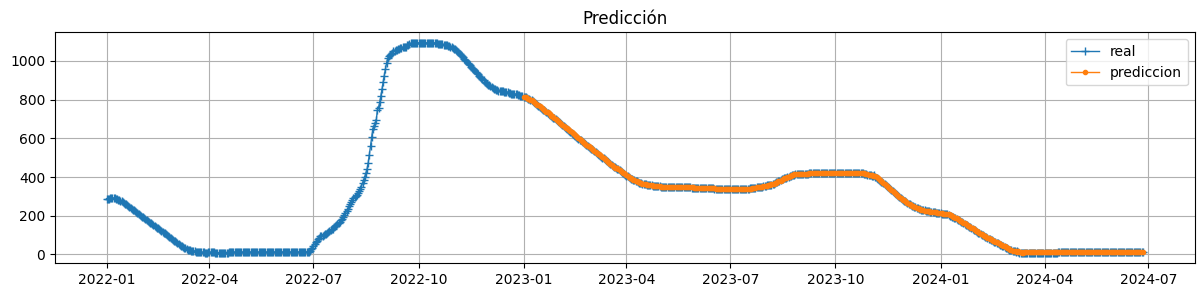

In [52]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.ARCSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [53]:
maximo = np.max(np.abs(set_validacion.ARCSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.ARCSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 8.4123811035156
La diferencia mínima es 0.006246337890615905


### 3.4 Presa ARLSO

#### 3.4.1 Construcción y entrenamiento del modelo

In [54]:
key = "X_train_ARLSO"
presa = "ARLSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para ARLSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - loss: 0.0036 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0036
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - loss: 1.7996e-05 - mean_absolute_error: 0.0017 - mean_squared_error: 1.7995e-05
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 225ms/step - loss: 1.7739e-05 - mean_absolute_error: 0.0017 - mean_squared_error: 1.7739e-05
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - loss: 2.2743e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 2.2743e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - loss: 1.7555e-05 - mean_absolute_error: 0.0019 - mean_squared_error: 1.7555e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - loss: 1.7819e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.7819e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 195ms/step - loss: 1.2926e-05 - mean_absolute_error: 0.0017 - mean_squared_error: 1.2926e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 194ms/step - los

#### 3.4.2 Guardar el modelo y el historial

In [55]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para ARLSO guardado como modelo_ARLSO.h5


#### 3.4.3 Validación y evaluación del modelo

In [56]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [57]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


In [58]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                
2023-01-01  19.644920
2023-01-02  19.632534
2023-01-03  19.477739
2023-01-04  19.327032
2023-01-05  19.141027
...               ...
2024-06-22   0.199076
2024-06-23   0.199076
2024-06-24   0.199075
2024-06-25   0.199076
2024-06-26   0.199078

[543 rows x 1 columns]

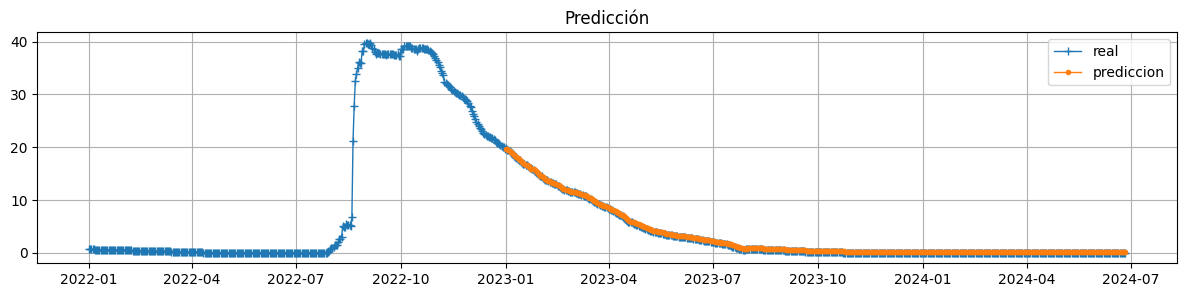

In [59]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.ARLSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [60]:
maximo = np.max(np.abs(set_validacion.ARLSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.ARLSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 0.3960154151916502
La diferencia mínima es 0.0029516601562491473


### 3.5 Presa CHTSO

#### 3.5.1 Construcción y entrenamiento del modelo

In [61]:
key = "X_train_CHTSO"
presa = "CHTSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para CHTSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - loss: 0.0186 - mean_absolute_error: 0.0559 - mean_squared_error: 0.0186
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step - loss: 2.4665e-04 - mean_absolute_error: 0.0070 - mean_squared_error: 2.4665e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - loss: 1.8170e-04 - mean_absolute_error: 0.0056 - mean_squared_error: 1.8169e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - loss: 2.4831e-04 - mean_absolute_error: 0.0057 - mean_squared_error: 2.4831e-04
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - loss: 1.1797e-04 - mean_absolute_error: 0.0050 - mean_squared_error: 1.1797e-04
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - loss: 1.3952e-04 - mean_absolute_error: 0.0046 - mean_squared_error: 1.3952e-04
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 245ms/step - loss: 9.0168e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 9.0168e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - loss:

#### 3.5.2 Guardar el modelo y el historial

In [62]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para CHTSO guardado como modelo_CHTSO.h5


#### 3.5.3 Validación y evaluación del modelo

In [63]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [64]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


In [65]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha               
2023-01-01  4.148777
2023-01-02  4.153580
2023-01-03  4.155547
2023-01-04  4.155048
2023-01-05  4.154567
...              ...
2024-06-22  0.513879
2024-06-23  0.488510
2024-06-24  0.480358
2024-06-25  0.466333
2024-06-26  0.434007

[543 rows x 1 columns]

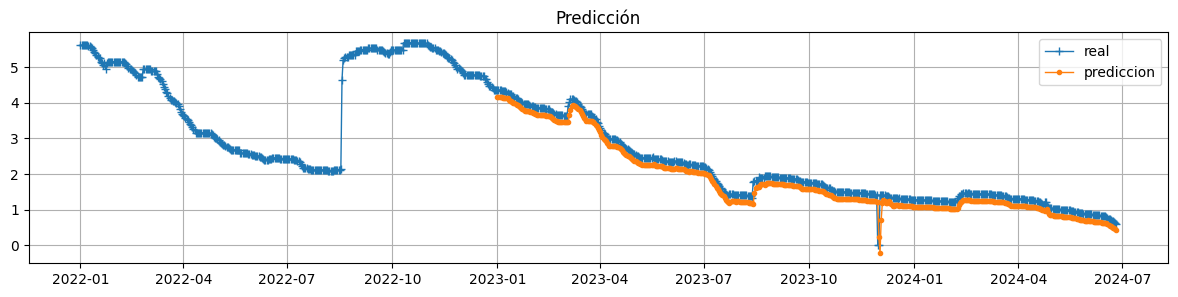

In [66]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.CHTSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [67]:
maximo = np.max(np.abs(set_validacion.CHTSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.CHTSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 1.6201767063140868
La diferencia mínima es 0.08987706279754648


### 3.6 Presa IRASO

#### 3.6.1 Construcción y entrenamiento del modelo

In [68]:
key = "X_train_IRASO"
presa = "IRASO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para IRASO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 219ms/step - loss: 0.0102 - mean_absolute_error: 0.0475 - mean_squared_error: 0.0102
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - loss: 2.4130e-04 - mean_absolute_error: 0.0067 - mean_squared_error: 2.4130e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - loss: 2.0718e-04 - mean_absolute_error: 0.0065 - mean_squared_error: 2.0718e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - loss: 1.4456e-04 - mean_absolute_error: 0.0055 - mean_squared_error: 1.4456e-04
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - loss: 1.2948e-04 - mean_absolute_error: 0.0050 - mean_squared_error: 1.2948e-04
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - loss: 1.4372e-04 - mean_absolute_error: 0.0051 - mean_squared_error: 1.4372e-04
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - loss: 1.3710e-04 - mean_absolute_error: 0.0050 - mean_squared_error: 1.3710e-04
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - los

#### 3.6.2 Guardar el modelo y el historial

In [69]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para IRASO guardado como modelo_IRASO.h5


#### 3.6.3 Validación y evaluación del modelo

In [70]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [71]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


In [72]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha               
2023-01-01  9.075288
2023-01-02  8.984174
2023-01-03  8.905335
2023-01-04  8.825583
2023-01-05  9.103579
...              ...
2024-06-22  0.010744
2024-06-23  0.010744
2024-06-24  0.010744
2024-06-25  0.010744
2024-06-26  0.010744

[543 rows x 1 columns]

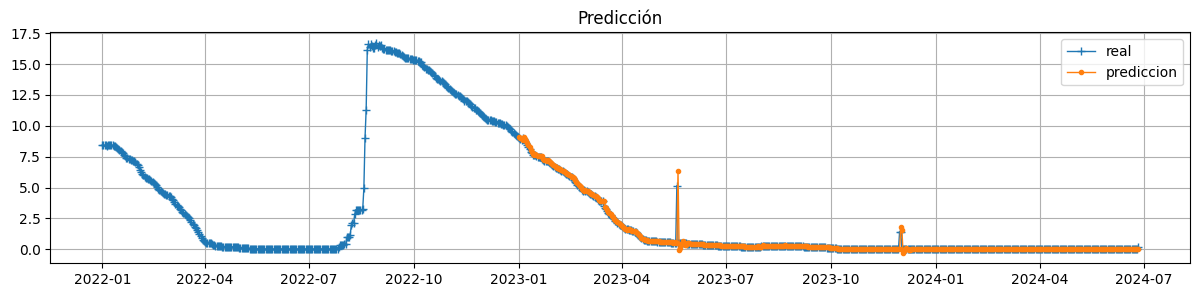

In [73]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.IRASO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [74]:
maximo = np.max(np.abs(set_validacion.IRASO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.IRASO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 5.868513336181641
La diferencia mínima es 0.0009471360826864839


### 3.7 Presa LCDSO

#### 3.7.1 Construcción y entrenamiento del modelo

In [75]:
key = "X_train_LCDSO"
presa = "LCDSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para LCDSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 202ms/step - loss: 0.0304 - mean_absolute_error: 0.0855 - mean_squared_error: 0.0304
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 198ms/step - loss: 7.9649e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 7.9649e-05
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - loss: 7.3465e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 7.3465e-05
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - loss: 5.6376e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 5.6380e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - loss: 5.6767e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 5.6766e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - loss: 6.0412e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 6.0411e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - loss: 6.5671e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 6.5671e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - los

#### 3.7.2 Guardar el modelo y el historial

In [76]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para LCDSO guardado como modelo_LCDSO.h5


#### 3.7.3 Validación y evaluación del modelo

In [77]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [78]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


In [79]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                 
2023-01-01  674.211670
2023-01-02  673.668396
2023-01-03  673.100464
2023-01-04  672.637878
2023-01-05  672.139221
...                ...
2024-06-22   84.463226
2024-06-23   84.413116
2024-06-24   84.166283
2024-06-25   83.634895
2024-06-26   83.035423

[543 rows x 1 columns]

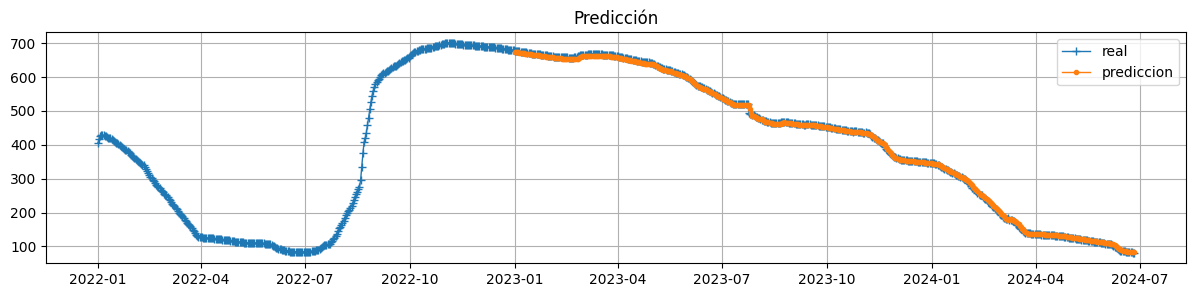

In [80]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.LCDSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [81]:
maximo = np.max(np.abs(set_validacion.LCDSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.LCDSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 22.691818847656236
La diferencia mínima es 0.04742004394530852


### 3.8 Presa PECSO

#### 3.8.1 Construcción y entrenamiento del modelo

In [82]:
key = "X_train_PECSO"
presa = "PECSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para PECSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 209ms/step - loss: 0.0449 - mean_absolute_error: 0.1155 - mean_squared_error: 0.0449
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - loss: 1.0318e-04 - mean_absolute_error: 0.0065 - mean_squared_error: 1.0318e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 199ms/step - loss: 7.3362e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 7.3361e-05
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 192ms/step - loss: 6.1834e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 6.1834e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - loss: 7.0690e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 7.0690e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - loss: 6.8350e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 6.8349e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - loss: 4.3539e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 4.3539e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - loss:

#### 3.8.2 Guardar el modelo y el historial

In [83]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para PECSO guardado como modelo_PECSO.h5


#### 3.8.3 Validación y evaluación del modelo

In [84]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [85]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [86]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                  
2023-01-01  1946.920532
2023-01-02  1937.263062
2023-01-03  1927.332520
2023-01-04  1917.189819
2023-01-05  1908.074585
...                 ...
2024-06-22   293.641510
2024-06-23   293.396698
2024-06-24   293.043243
2024-06-25   294.052734
2024-06-26   295.390656

[543 rows x 1 columns]

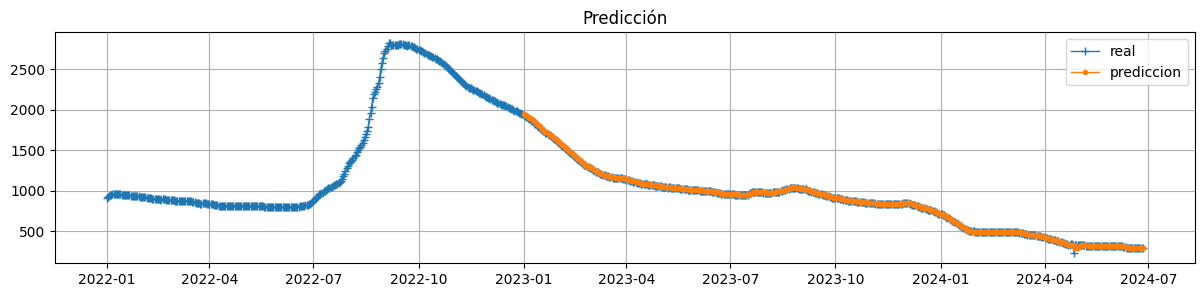

In [87]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.PECSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [88]:
maximo = np.max(np.abs(set_validacion.PECSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.PECSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 97.48618725585936
La diferencia mínima es 0.04336059570312045


### 3.9 Presa PMOSO

#### 3.9.1 Construcción y entrenamiento del modelo

In [89]:
key = "X_train_PMOSO"
presa = "PMOSO"

# Obtener X_train y Y_train para la presa actual
X_train = X_train_dict[key]
Y_train = Y_train_dict[f'Y_train_{presa}']

# Crear el modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_step, 1)
modelo = crear_modelo(input_shape, nodes=150, lr=0.01)

# Entrenar el modelo y medir el tiempo de entrenamiento
print(f"Entrenando modelo para {presa}...")
start_time = time.time()
historial = modelo.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
print(f"Tiempo de entrenamiento para {presa}: {end_time - start_time} segundos")

# Almacenar historial de entrenamiento
historiales[presa] = historial

Entrenando modelo para PMOSO...
Epoch 1/10


c:\Users\EstephaniaPivacAlcar\miniconda3\envs\env-sgd2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 203ms/step - loss: 0.0016 - mean_absolute_error: 0.0183 - mean_squared_error: 0.0016
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 57s 191ms/step - loss: 6.8731e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 6.8731e-05
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 354ms/step - loss: 2.9410e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 2.9410e-05
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - loss: 3.2495e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 3.2495e-05
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - loss: 2.8079e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.8079e-05
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 196ms/step - loss: 1.8379e-05 - mean_absolute_error: 0.0019 - mean_squared_error: 1.8379e-05
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 198ms/step - loss: 1.6360e-05 - mean_absolute_error: 0.0020 - mean_squared_error: 1.6360e-05
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - lo

#### 3.9.2 Guardar el modelo y el historial

In [90]:
# Crear la ruta para la carpeta "model" dentro del directorio actual
model_filename = f'modelo_{presa}.h5'
ruta_modelo = os.path.join(".", "modelos")

# Verificar si la carpeta "model" existe
if not os.path.exists(ruta_modelo):
    # Si no existe, crear la carpeta
    os.makedirs(ruta_modelo)

# Guardar el modelo en la ruta especificada por path_model
path_modelo = os.path.join(ruta_modelo,  model_filename)
modelo.save(path_modelo)

# Guardar el modelo y el historial
print(f"Modelo para {presa} guardado como {model_filename}")

# Guardar el historial en un archivo CSV en la misma ruta
historial_df = pd.DataFrame(historial.history)
path_historial = os.path.join(ruta_modelo, f'historial_entrenamiento_{presa}.csv')
historial_df.to_csv(path_historial, index=False)

Modelo para PMOSO guardado como modelo_PMOSO.h5


#### 3.9.3 Validación y evaluación del modelo

In [91]:
# Obtener X_train y Y_train para la presa actual
X_test = X_valid_dict[f'X_valid_{presa}']
Y_test = Y_valid_dict[f'Y_valid_{presa}']

In [92]:
prediccion = modelo.predict( X_test )

scaler_name = f'scaler_{presa}'
prediccion = globals()[scaler_name].inverse_transform(prediccion)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


In [93]:
df_prediccion = pd.DataFrame(prediccion, index=set_validacion.index[time_step:])
df_prediccion

0
Fecha                
2023-01-01  37.186069
2023-01-02  37.477783
2023-01-03  37.427811
2023-01-04  37.388897
2023-01-05  37.303436
...               ...
2024-06-22   5.900257
2024-06-23   5.844707
2024-06-24   5.868329
2024-06-25   5.875710
2024-06-26   5.799070

[543 rows x 1 columns]

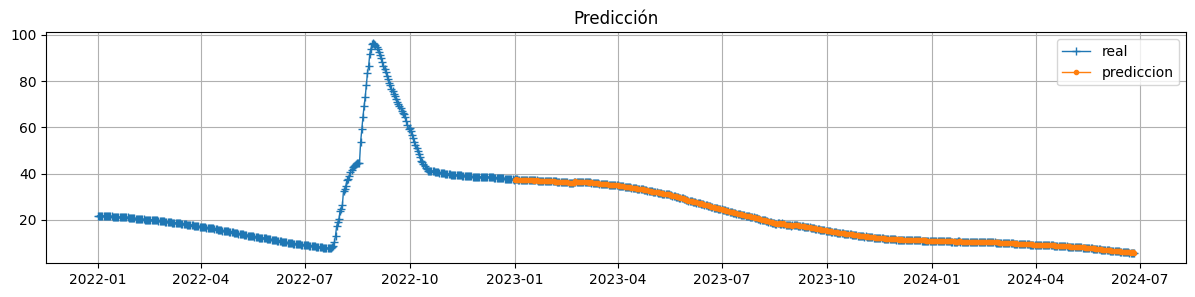

In [94]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción")
#ax1.plot( set_entrenamiento.AGZCH, marker = '+', linewidth = 1 )
ax1.plot( set_validacion.PMOSO, marker = '+', linewidth = 1 )
ax1.plot( df_prediccion[0], marker = '.', linewidth = 1 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

In [95]:
maximo = np.max(np.abs(set_validacion.PMOSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))
minimo_valor = np.min(np.abs(set_validacion.PMOSO[:df_prediccion.shape[0]+time_step] - df_prediccion[0]))

print("La diferencia máxima es", maximo)
print("La diferencia mínima es", minimo_valor)

La diferencia máxima es 0.612814819335938
La diferencia mínima es 0.0003532409667954539
